# 图像变换与去噪

## 实验目的
1. 试对附件中的图片施加仿射变换、透视变换，输出相应的图片。
2. 试滤除图片中的噪声信号。

## 实验环境
- OpenCV2
- NumPy
- MatPlotLib

In [62]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## 实验原理

二维平面上点$(x,y)^T$的齐次坐标表示为$(x,y,1)^T$

### 仿射变换（Affine Transformation）
仿射变换是一种保持平行性的几何变换，可以通过矩阵乘法表示。它包含旋转、缩放、平移和剪切等操作。仿射变换保留了直线性和平行性，但不保留距离和角度。

数学上，仿射变换可以表示为以下形式：

$$\mathbf{T}(\mathbf{x}) = \mathbf{A} \cdot \mathbf{x} + \mathbf{b}$$

其中：
- $\mathbf{x} = \begin{pmatrix} x \\ y \end{pmatrix}$ 表示二维空间中的点。
- $\mathbf{A} = \begin{pmatrix} t_{11} & t_{12} \\ t_{21} & t_{22} \end{pmatrix}$ 是一个 $2 \times 2$ 矩阵，定义了旋转、缩放和剪切。
- $\mathbf{b} = \begin{pmatrix} b_x \\ b_y \end{pmatrix}$ 是一个平移向量，定义了变换中的平移部分。

用齐次坐标也可以表示为$\begin{pmatrix} t_{11} & t_{12} & b_x \\ t_{21} & t_{22} & b_y \\ 0 & 0 & 0 \end{pmatrix}$

### 透视变换（Perspective Transformation）
透视变换，也就是射影变换，是一种更一般的变换，适用于三维物体在二维平面上的投影。它会导致直线在图像上收敛，类似于人类的视角感知，常用于处理图像中的视角变化。



透视变换可以用一个 $3 \times 3$ 的矩阵$\mathbf{H} = \begin{pmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{pmatrix}$来表示：

$$\begin{pmatrix} x' \\ y' \\ w' \end{pmatrix} = \mathbf{H} \cdot \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$$

最终的坐标 $(x', y')^T$ 是通过归一化计算得到的：

$$x' = \frac{x'}{w'}, \quad y' = \frac{y'}{w'}$$

### 傅里叶变换（Fourier Transform）
傅里叶变换是一种将时域或空间域的信号转换为频域表示的数学变换。它在信号处理、图像处理等领域中广泛应用，主要用于分析信号的频率成分。

二维傅里叶变换（适用于图像）将空间域中的图像 $f(x, y)$ 转换为频域表示 $F(u, v)$，其数学形式如下：

$$
F(u, v) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x, y) e^{-j 2\pi (ux + vy)} \, dx \, dy
$$

傅里叶变换的物理意义在于，它将图像中的每个像素值分解为不同的频率成分，可以用于检测图像中的边缘、去除噪声、图像压缩等任务。

## 实验方法

### 仿射变换
PIL提供的`transform`方法可以直接将变换矩阵作用于图像，传入`method=Transform.AFFINE`的同时传入变换矩阵的逆矩阵的6个参数即可。

In [63]:
def affine_trans(pic: Image.Image, T: np.ndarray, b: np.ndarray) -> Image.Image:
    inv_T = np.linalg.inv(T)
    inv_b = -b
    data = np.concatenate((inv_T, inv_b.reshape(2, 1)), axis=1).flatten()
    pic = pic.transform(pic.size, Image.AFFINE, data, Image.BICUBIC)
    return pic

### 透视变换
同上。传入`method=Transform.PERSPECTIVE`的同时传入变换矩阵的逆矩阵的前8个参数即可。

In [64]:
def perspective_trans(pic: Image.Image, H: np.ndarray) -> Image.Image:
    inv_H = np.linalg.inv(H)
    data = inv_H.flatten()[:8]
    pic = pic.transform(pic.size, Image.PERSPECTIVE, data, Image.BICUBIC)
    return pic

### 去噪
![init_lena](lena.png)

观察到图像噪声为有规律的条纹，考虑到其为固定频率的噪声。先对图像进行傅里叶变换得到频谱：

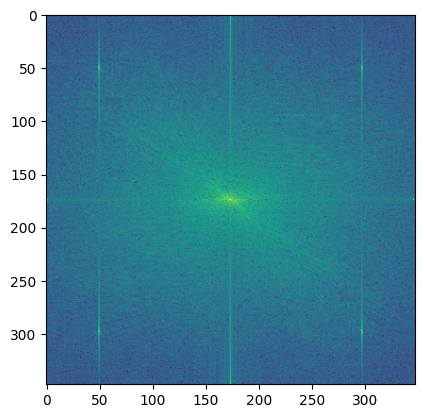

In [65]:
img = np.array(Image.open('lena.png').convert('L'))
f_img = np.fft.fft2(img)
f_shift = np.fft.fftshift(f_img)
f_shift = 20*np.log(np.abs(f_shift) + 1)
f_shift = f_shift.astype(np.uint16)
f_shift = Image.fromarray(f_shift)
plt.imshow(f_shift)

发现在$\pm125$的频率有两处明显的噪声带，可以在频谱上对应位置覆盖掩码，然后从周围采样填充。

## 实验过程

### 仿射变换
利用矩阵$\begin{pmatrix} 0.07&0.3&100 \\ 0.5&0.07&50 \\ 0&0&0 \end{pmatrix}$进行仿射变换。

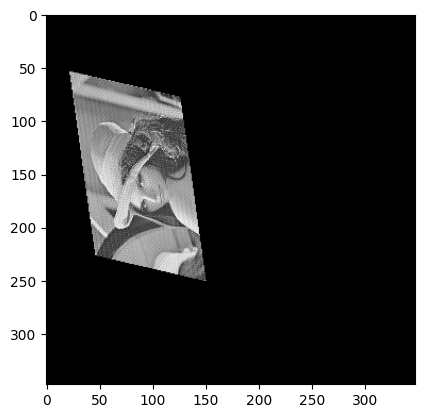

In [78]:
T = np.array([[0.07, 0.3], [0.5, 0.07]])
b = np.array([100, 50])
pic = Image.open('lena.png').convert('L')
pic = affine_trans(pic, T, b)
plt.imshow(pic, cmap='gray')

### 透视变换
利用矩阵$\begin{pmatrix} 1&0.5&100 \\ 0.5&1&50 \\ 0.001&0.001&1 \end{pmatrix}$进行透视变换。

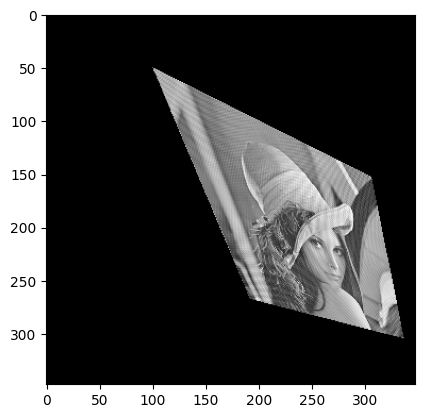

In [74]:
H = np.array([[1, 0.5, 100], [0.5, 1, 50], [0.001, 0.001, 1]])
pic = Image.open('lena.png').convert('L')
pic = perspective_trans(pic, H)
plt.imshow(pic, cmap='gray')

### 去噪

